In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import glob
import re
import random
import os
from itertools import groupby

In [2]:
# default parameters
param = {'act_func': 'linear',
         'epoch_n': 1000,
         'save_interval': 500,
         'r1_size': 100,
         's10': 10,
         's11': 1,
         's21': 10,
         's22': 1,
         's32': 5,
         'alpha_1': 0.1,
         'alpha_2': 5,
         'beta_1': 0.1,
         'beta_2': 0.1,
         'gamma_1': 0.01,
         'gamma_2': 0.01,
         'in_dir': './data/3x3/',
         'out_dir': './results'}

In [3]:
param = pd.Series(param)
param

act_func              linear
epoch_n                 1000
save_interval            500
r1_size                  100
s10                       10
s11                        1
s21                       10
s22                        1
s32                        5
alpha_1                  0.1
alpha_2                    5
beta_1                   0.1
beta_2                   0.1
gamma_1                 0.01
gamma_2                 0.01
in_dir           ./data/3x3/
out_dir            ./results
dtype: object

In [4]:
def softmax(x, c=1):
    x = np.array(x)
    x = x - x.max()
    return np.exp(x*c)/np.sum(np.exp(x*c))

In [5]:
def f(x, af="linear"):
    '''
    Applies activation function.
    '''
    if af == "linear":
        fx = x
    elif af == "tanh":
        fx = np.tanh(x)
    return fx

In [6]:
def f_prime(x, af="linear"):
    '''
    Derivative of activation function.
    '''
    if af == "linear":
        dfx = np.eye(x.size)
    elif af == "tanh":
        dfx = np.diag(1 - np.square(np.tanh(x)))
    return dfx

In [7]:
def apply_input(I_dict, training=False, af="linear", seed=None):
    global U1_hat, U2_hat, V1_hat, V2_hat
    
    output = {"training": [], "input": [], "label": [], "target_vec": [], "timestep": [],
              "r1_bar": [], "r2_bar": [], "r2_bar_x": [],
              "r1_hat": [], "r2_hat": [], "r2_hat_x": [],
              "U1_bar": [], "U2_bar": [], "V1_bar": [],  "V2_bar": [],
              "U1_hat": [], "U2_hat": [], "V1_hat": [],  "V2_hat": []}
    
    if training == True:
        np.random.seed(seed)
        I_order = random.sample(list(I_dict.keys()), len(list(I_dict.keys())))
    elif training == False:
        I_order = list(I_dict.keys())
    
    for k in I_order:
        I = I_dict[k]
        k_idx = list(I_dict.keys()).index(k)
        L = np.eye(len(I_dict))[k_idx]

        r1_hat = r1.copy()
        r2_hat = r2.copy()
        r2_hat_x = r2.copy()

        for idx in np.arange(I.shape[1]):
            r1_hat_old = r1_hat.copy()
            r2_hat_old = r2_hat.copy()
            r2_hat_x_old = r2_hat_x.copy()

            U1_bar = U1_hat.copy()
            U2_bar = U2_hat.copy()

            V1_bar = V1_hat.copy()
            V2_bar = V2_hat.copy()
            
            r1_bar = f(V1_bar @ r1_hat_old, af=af)
            r2_bar = f(V2_bar @ r2_hat_old, af=af)
            r2_bar_x = f(V2_bar @ r2_hat_x_old, af=af)

            r1_hat = r1_bar + alpha_1/s10 * U1_bar.T @ f_prime(U1_bar @ r1_bar, af=af) @ (I[:, idx] - f(U1_bar @ r1_bar, af=af)) - alpha_1/s21 * (r1_bar - f(U2_bar @ r2_bar, af=af))
            r2_hat = r2_bar + alpha_2/s21 * U2_bar.T @ f_prime(U2_bar @ r2_bar, af=af) @ (r1_bar - f(U2_bar @ r2_bar, af=af))
            r2_hat_x = r2_hat - 1/2 * alpha_2/s32 * (softmax(r2_bar) - L)

            if training == True:
                U1_hat = U1_bar + beta_1/s10 * f_prime(U1_bar @ r1_hat, af=af) @ np.outer(I[:, idx] - f(U1_bar @ r1_hat, af=af), r1_hat)
                U2_hat = U2_bar + beta_2/s21 * f_prime(U2_bar @ r2_hat_x, af=af) @ np.outer(r1_bar - f(U2_bar @ r2_hat_x, af=af), r2_hat_x)

                V1_hat = V1_bar + gamma_1/s11 * f_prime(V1_bar @ r1_hat_old, af=af) @ np.outer(r1_hat - f(V1_bar @ r1_hat_old, af=af), r1_hat_old)
                V2_hat = V2_bar + gamma_2/s22 * f_prime(V2_bar @ r2_hat_x_old, af=af) @ np.outer(r2_hat_x - f(V2_bar @ r2_hat_x_old, af=af), r2_hat_x_old)
            
            output["training"].append(training)
            output["input"].append(I[:, idx])
            output["label"].append(k)
            output["target_vec"].append(L)
            output["timestep"].append(idx)

            output["r1_bar"].append(r1_bar.copy())
            output["r2_bar"].append(r2_bar.copy())
            output["r2_bar_x"].append(r2_bar_x.copy())
            
            output["r1_hat"].append(r1_hat.copy())
            output["r2_hat"].append(r2_hat.copy())
            output["r2_hat_x"].append(r2_hat_x.copy())

            output["U1_bar"].append(U1_bar.copy())
            output["U2_bar"].append(U2_bar.copy())
            output["V1_bar"].append(V1_bar.copy())
            output["V2_bar"].append(V2_bar.copy())
            
            output["U1_hat"].append(U1_hat.copy())
            output["U2_hat"].append(U2_hat.copy())            
            output["V1_hat"].append(V1_hat.copy())
            output["V2_hat"].append(V2_hat.copy())
    
    output_df = pd.DataFrame.from_dict(output)
    
    return output_df

In [8]:
def raw_vs_softmax_plots(df, ncols, nrows, subplot_yx, scale, groupby, value, sharex=False, sharey=False, cmap=None):
    subplot_y, subplot_x = tuple(i * scale for i in (subplot_yx))

    fig, axes = plt.subplots(nrows, ncols, figsize=(subplot_x*ncols, subplot_y*nrows), sharex=sharex, sharey=sharey)
    
    df_groupby = df.groupby(groupby)
    group_keys = df_groupby.groups.keys()
    
    for k in group_keys:
        k_idx = list(group_keys).index(k)

        raw_r = df_groupby.get_group(k).apply(lambda x: pd.Series(x[value]), axis=1).reset_index(drop=True)
        softmaxd_r = df_groupby.get_group(k).apply(lambda x: pd.Series(softmax(x[value])), axis=1).reset_index(drop=True)

        raw_r.columns = group_keys
        softmaxd_r.columns = group_keys

        raw_plot = raw_r.plot(ax=axes[k_idx, 0], title="{}: raw activations".format(k), cmap=cmap);
        softmaxd_plot = softmaxd_r.plot(ax=axes[k_idx, 1], title="{}: softmax'd activations".format(k), cmap=cmap);
        
        raw_plot.legend(loc="lower left");
        softmaxd_plot.legend(loc="lower left");
        
        # thicken target line
        for i, l1, l2 in zip(range(len(group_keys)), raw_plot.lines, softmaxd_plot.lines):
            if i == k_idx:
                plt.setp(l1, linewidth=3)
                plt.setp(l2, linewidth=3)

    plt.tight_layout();

In [9]:
def recon_plots(df, ncols, nrows, subplot_yx, scale, groupby, value, sharex=True, sharey=True, cmap="gray", y_label_list=None):
    subplot_y, subplot_x = tuple(i * scale for i in (subplot_yx))

    fig, axes = plt.subplots(nrows, ncols, figsize=(subplot_x*ncols, subplot_y*nrows), sharex=sharex, sharey=sharey)

    df_groupby = df.groupby(groupby)
    group_keys = df_groupby.groups.keys()
    
    vmin = df.apply(lambda x: pd.Series(x[value]), axis=1).values.min()
    vmax = df.apply(lambda x: pd.Series(x[value]), axis=1).values.max()
    
    for k, ax in zip(group_keys, axes.flatten()):
        vall = df_groupby.get_group(k).apply(lambda x: pd.Series(x[value]), axis=1).values.T
        im = ax.imshow(vall, cmap=cmap, vmin=vmin, vmax=vmax)
    
        if y_label_list != None:
            ax.set_yticks(range(len(y_label_list)))
            ax.set_yticklabels(y_label_list)

        ax.set_title(k)

    fig.colorbar(im, ax=axes.ravel().tolist());

In [10]:
def argmax_1(x):
    '''
    refined argmax which only returns the index when there is only one element with the maximum value, otherwise returns NaN
    '''
    x = np.array(x)
    max_marks = [1 if i == x.max() else 0 for i in x]
    argmax_x = np.argmax(max_marks) if np.sum(max_marks) == 1 else np.nan
    return argmax_x

def recog(L, steps=3):
    '''
    select the node that first stays at the maximum for a certain number of time steps
    '''
    X = np.array([[k, sum(1 for i in g)] for k, g in groupby(L)])
    df = pd.DataFrame(X, columns=["max_node", "steps"])
    max_nodes = df.query("steps >= {}".format(steps))["max_node"]
    recog_node = max_nodes.iloc[0] if len(max_nodes) > 0 else np.nan
    return recog_node

# Inputs

In [11]:
in_dir = param.in_dir
I_filenames = glob.glob(os.path.join(in_dir, "*.png"))
I_dict = {}

for i in I_filenames:
    I = cv2.imread(i)
    I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
    I = I/255
    
    I_id = re.sub(r".*_(.*)\.png", r"\1", i)
    
    I_dict.update({I_id: I})

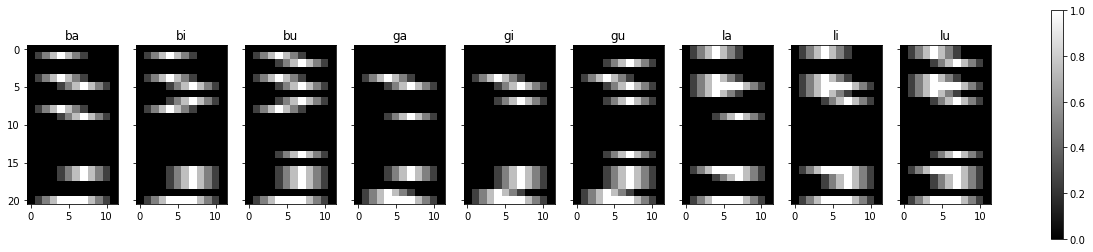

In [12]:
ncols = len(I_dict)
nrows = 1

subplot_y, subplot_x = I.shape
scale = 0.2
subplot_y, subplot_x = tuple(i * scale for i in (subplot_y, subplot_x))

fig, axes = plt.subplots(nrows, ncols, figsize=(subplot_x*ncols, subplot_y*nrows), sharex=True, sharey=True)

for k, ax in zip(I_dict.keys(), axes.flatten()):
    im = ax.imshow(I_dict[k], cmap="gray")
    ax.set_title(k)
    
fig.colorbar(im, ax=axes.ravel().tolist());

# Parameters

In [13]:
act_func = param.act_func

epoch_n = param.epoch_n
epoch_max = max(range(epoch_n))

save_interval = param.save_interval

vec_len = len(I_dict)
I_size = I.shape[0]
r1_size = param.r1_size
r2_size = vec_len

r1 = np.zeros(r1_size)
r2 = np.zeros(r2_size)

np.random.seed(1)
U1 = np.random.normal(loc=0, scale=0.1, size=(I_size, r1_size))
U2 = np.random.normal(loc=0, scale=0.1, size=(r1_size, r2_size))
V1 = np.random.normal(loc=0, scale=0.1, size=(r1_size, r1_size))
V2 = np.random.normal(loc=0, scale=0.1, size=(r2_size, r2_size))

s10 = param.s10
s11 = param.s11
s21 = param.s21
s22 = param.s22
s32 = param.s32

alpha_1 = param.alpha_1
alpha_2 = param.alpha_2

beta_1 = param.beta_1
beta_2 = param.beta_2

gamma_1 = param.gamma_1
gamma_2 = param.gamma_2

# Before Training

In [14]:
U1_hat = U1.copy()
U2_hat = U2.copy()
V1_hat = V1.copy()
V2_hat = V2.copy()

output_test_df = apply_input(I_dict, training=False, af=act_func)

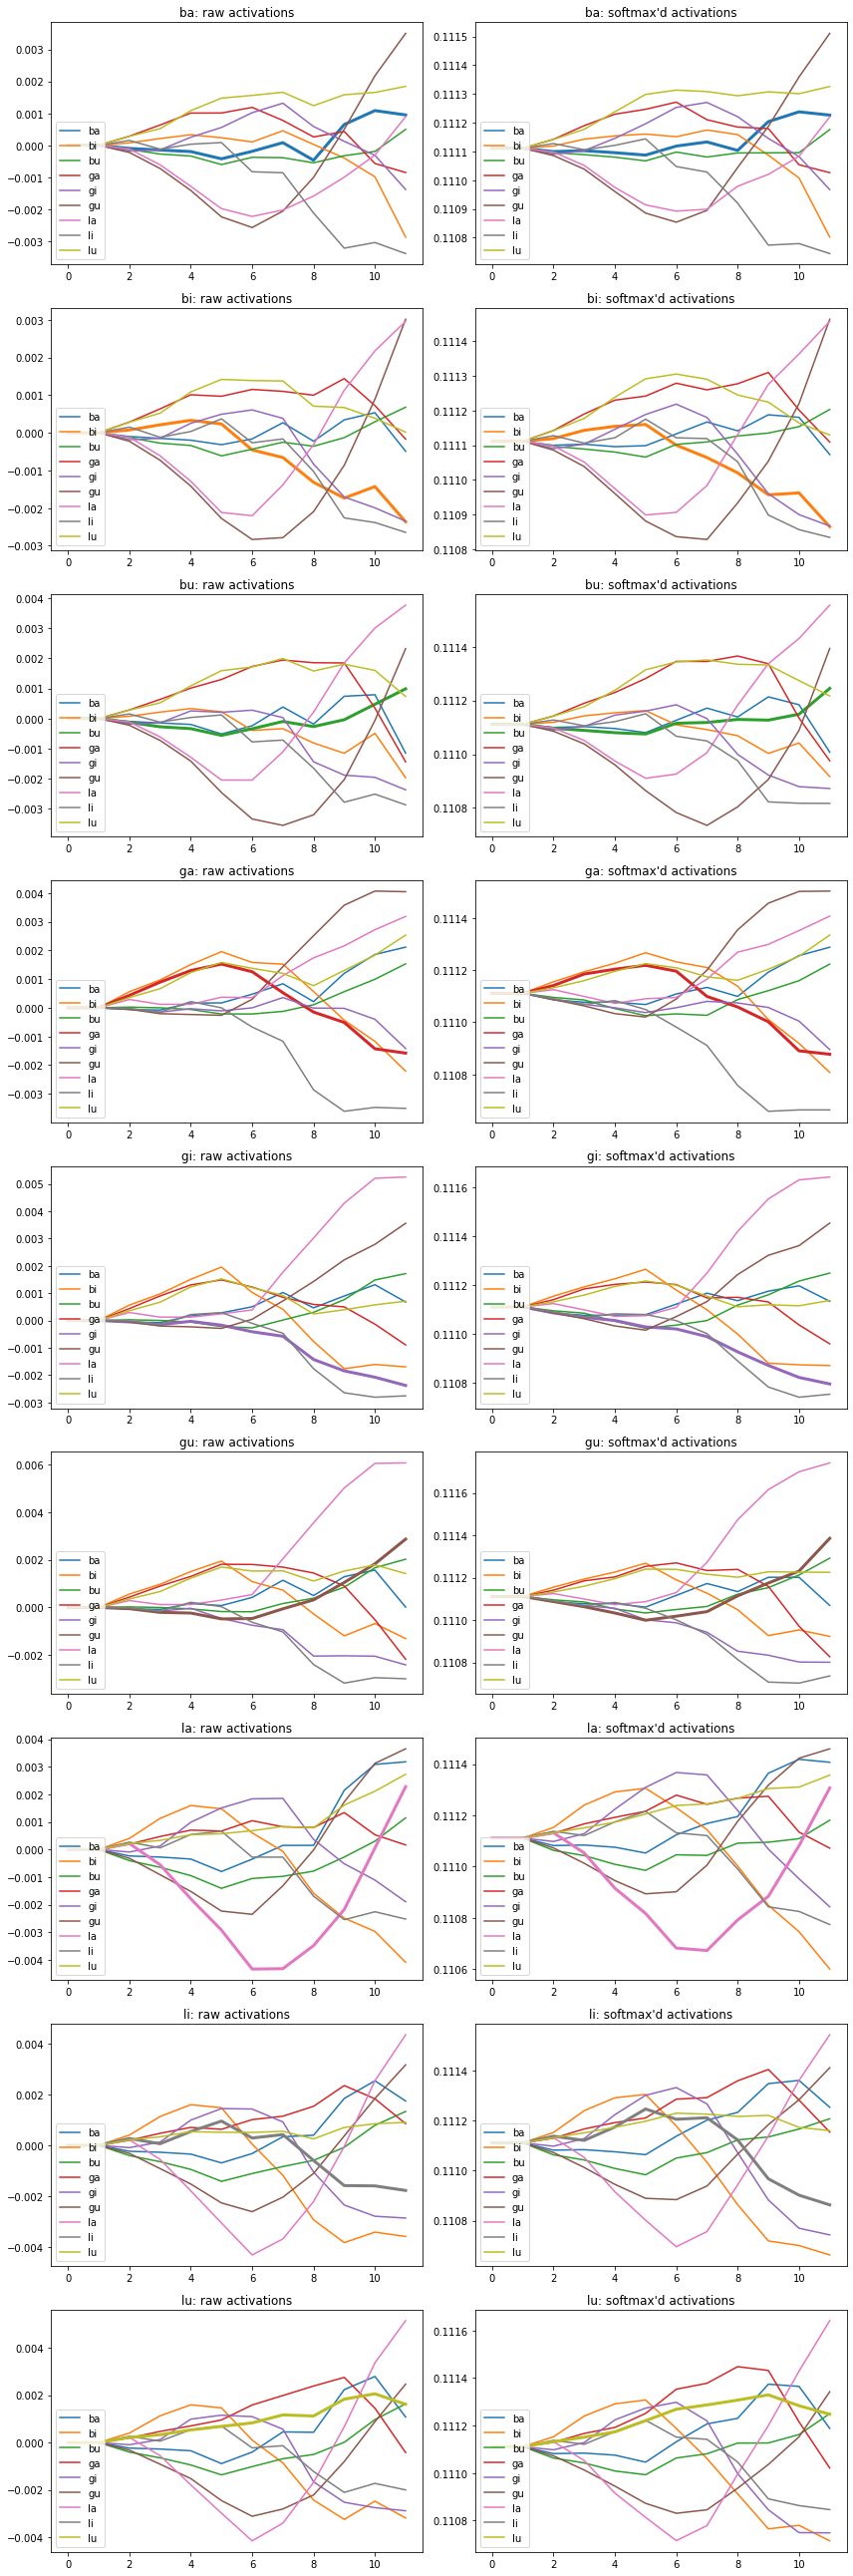

In [15]:
raw_vs_softmax_plots(df=output_test_df, ncols=2, nrows=9, subplot_yx=(4,6), scale=1, groupby="label", value="r2_hat")

# Training & Testing

In [16]:
U1_hat = U1.copy()
U2_hat = U2.copy()
V1_hat = V1.copy()
V2_hat = V2.copy()

output_train_list = []
output_test_list = []

for epoch in np.arange(epoch_n):
    output_train_i = apply_input(I_dict, training=True, af=act_func, seed=epoch)
    output_train_i["epoch"] = epoch
    if epoch % save_interval == save_interval-1:
        output_train_list.append(output_train_i)
        
        output_test_i = apply_input(I_dict, training=False, af=act_func)
        output_test_i["epoch"] = epoch
        output_test_list.append(output_test_i)

output_train_df = pd.concat(output_train_list)
output_test_df = pd.concat(output_test_list)

## Training Timecourse at Last Epoch

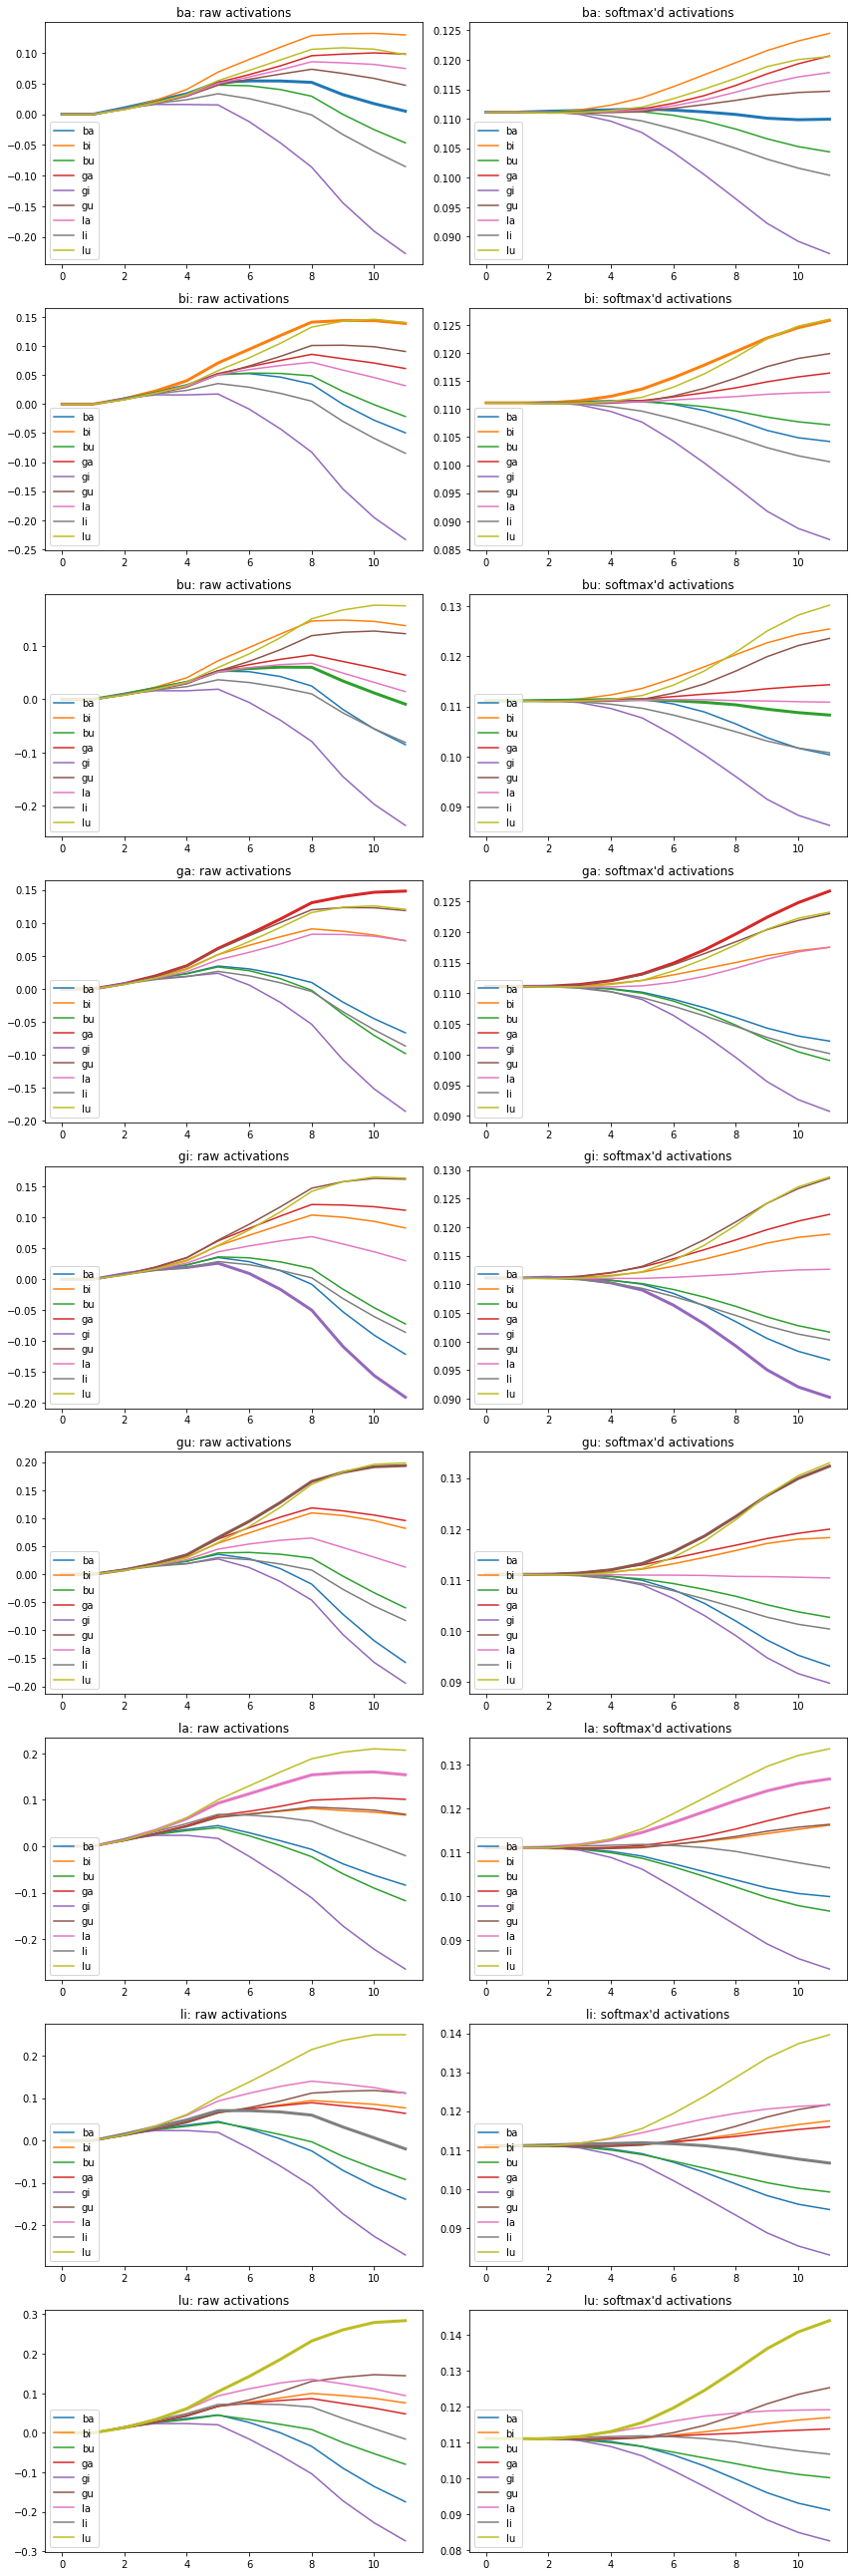

In [17]:
raw_vs_softmax_plots(df=output_train_df.groupby("epoch").get_group(epoch_max),
                     ncols=2, nrows=9, subplot_yx=(4,6), scale=1, groupby="label", value="r2_hat")

## Testing Timecourse at Last Epoch

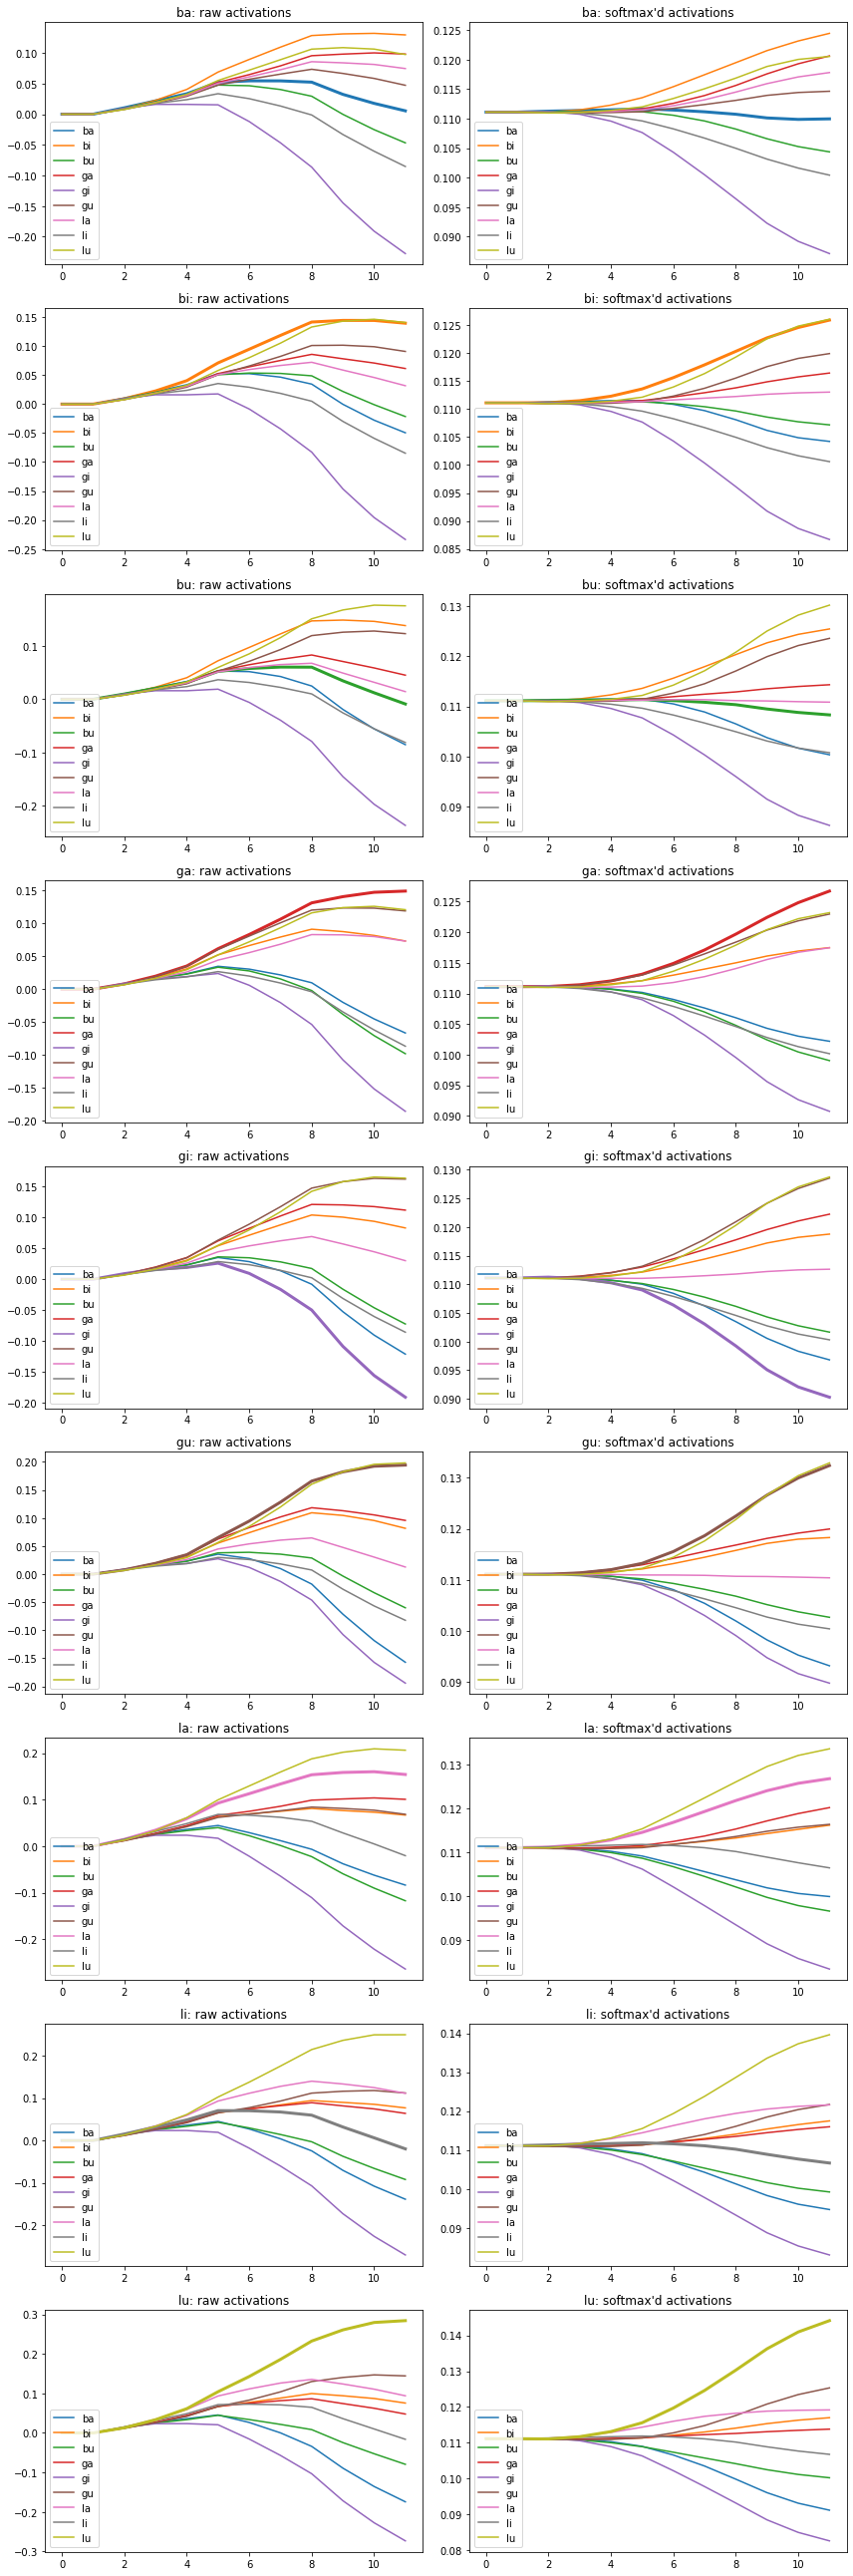

In [18]:
raw_vs_softmax_plots(df=output_test_df.groupby("epoch").get_group(epoch_max),
                     ncols=2, nrows=9, subplot_yx=(4,6), scale=1, groupby="label", value="r2_hat")

# Input Reconstruction

In [19]:
ncols = len(I_dict)
nrows = 1
subplot_yx = I.shape
scale = 0.2

## Actual Inputs

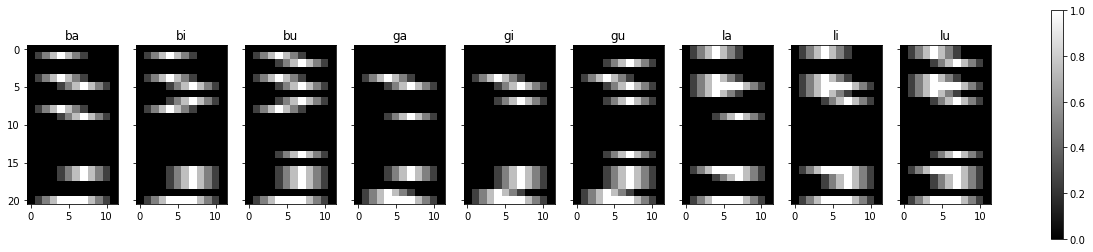

In [20]:
recon_plots(df=output_test_df.groupby("epoch").get_group(epoch_max),
            ncols=ncols, nrows=nrows, subplot_yx=subplot_yx, scale=scale, groupby="label", value="input")

## Reconstruction Based on r1_hat

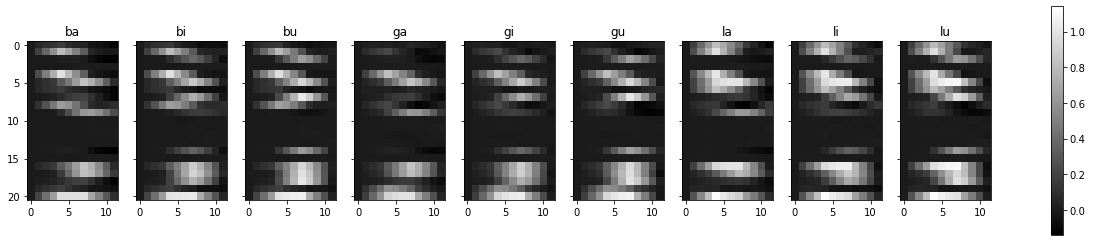

In [21]:
output_test_df["r1_hat_recon"] = output_test_df.apply(lambda x: x.U1_hat @ x.r1_hat, axis=1)

recon_plots(df=output_test_df.groupby("epoch").get_group(epoch_max),
            ncols=ncols, nrows=nrows, subplot_yx=subplot_yx, scale=scale, groupby="label", value="r1_hat_recon")

## Reconstruction Based on r1_bar

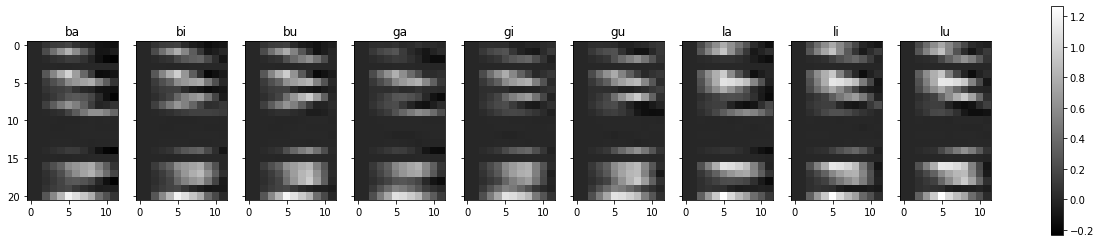

In [22]:
output_test_df["r1_bar_recon"] = output_test_df.apply(lambda x: x.U1_hat @ x.r1_bar, axis=1)

recon_plots(df=output_test_df.groupby("epoch").get_group(epoch_max),
            ncols=ncols, nrows=nrows, subplot_yx=subplot_yx, scale=scale, groupby="label", value="r1_bar_recon")

## Differences of Reconstruction of r1_bar and r1_hat

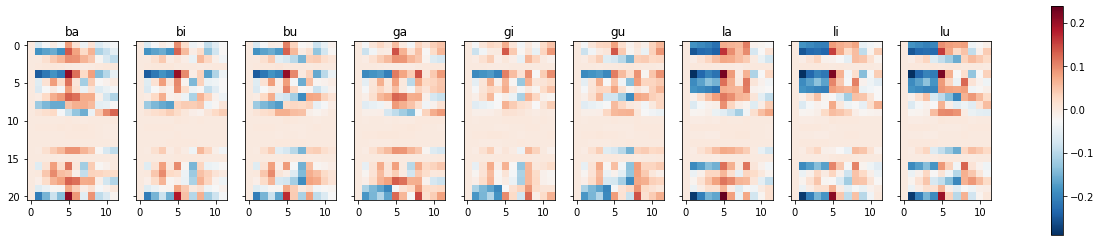

In [23]:
output_test_df["r1_recon_diff"] = output_test_df.apply(lambda x: x.r1_bar_recon - x.r1_hat_recon, axis=1)

recon_plots(df=output_test_df.groupby("epoch").get_group(epoch_max),
            ncols=ncols, nrows=nrows, subplot_yx=subplot_yx, scale=scale, groupby="label", value="r1_recon_diff", cmap="RdBu_r")

# Target Reconstruction

In [24]:
ncols = len(I_dict)
nrows = 1
subplot_yx = (len(I_dict), I.shape[1])
scale = 0.3

## Actual Target Vector

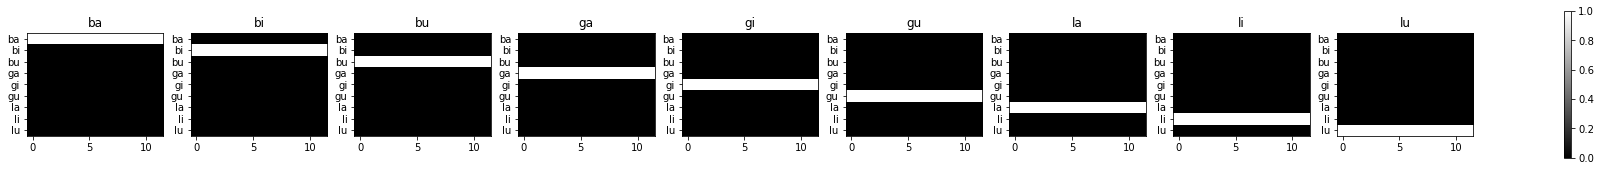

In [25]:
recon_plots(df=output_test_df.groupby("epoch").get_group(epoch_max),
            ncols=ncols, nrows=nrows, subplot_yx=subplot_yx, scale=scale,
            groupby="label", value="target_vec", sharey=False, y_label_list=list(I_dict.keys()))

## Raw r2_hat_x During Training

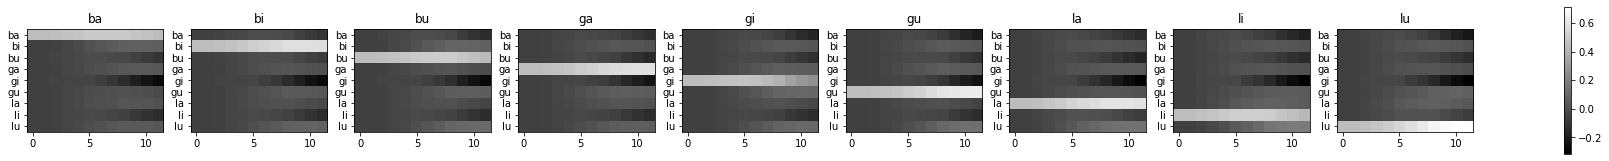

In [26]:
recon_plots(df=output_train_df.groupby("epoch").get_group(epoch_max),
            ncols=ncols, nrows=nrows, subplot_yx=subplot_yx, scale=scale,
            groupby="label", value="r2_hat_x", sharey=False, y_label_list=list(I_dict.keys()))

## Softmax'd r2_hat_x During Training

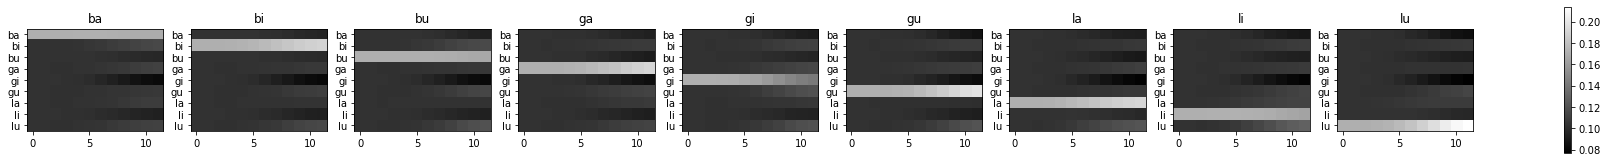

In [27]:
output_train_df["softmaxd_r2_hat_x"] = output_train_df.apply(lambda x: softmax(x.r2_hat_x), axis=1)

recon_plots(df=output_train_df.groupby("epoch").get_group(epoch_max),
            ncols=ncols, nrows=nrows, subplot_yx=subplot_yx, scale=scale,
            groupby="label", value="softmaxd_r2_hat_x", sharey=False, y_label_list=list(I_dict.keys()))

## Raw r2_hat During Training

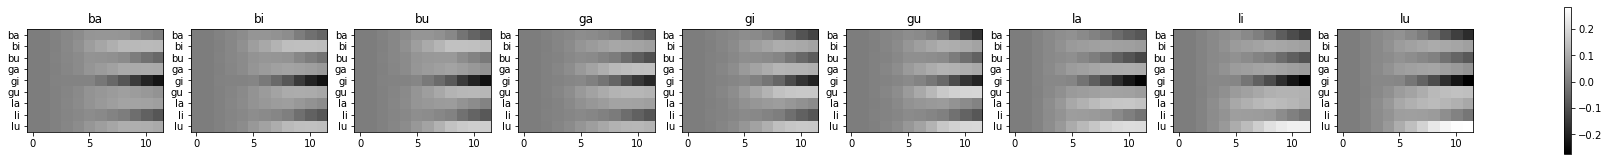

In [28]:
recon_plots(df=output_train_df.groupby("epoch").get_group(epoch_max),
            ncols=ncols, nrows=nrows, subplot_yx=subplot_yx, scale=scale,
            groupby="label", value="r2_hat", sharey=False, y_label_list=list(I_dict.keys()))

## Softmax'd r2_hat During Training

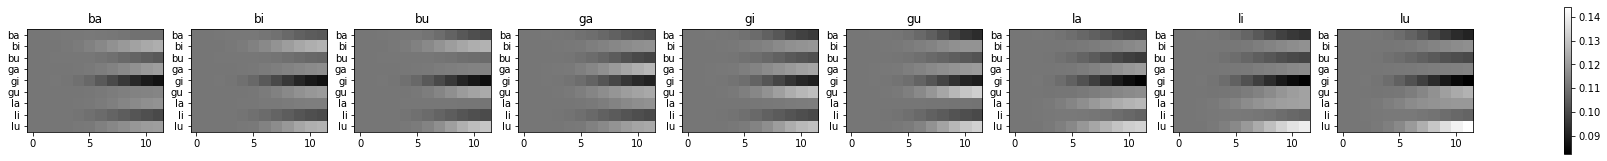

In [29]:
output_train_df["softmaxd_r2_hat"] = output_train_df.apply(lambda x: softmax(x.r2_hat), axis=1)

recon_plots(df=output_train_df.groupby("epoch").get_group(epoch_max),
            ncols=ncols, nrows=nrows, subplot_yx=subplot_yx, scale=scale,
            groupby="label", value="softmaxd_r2_hat", sharey=False, y_label_list=list(I_dict.keys()))

## Softmax'd r2_hat During Testing

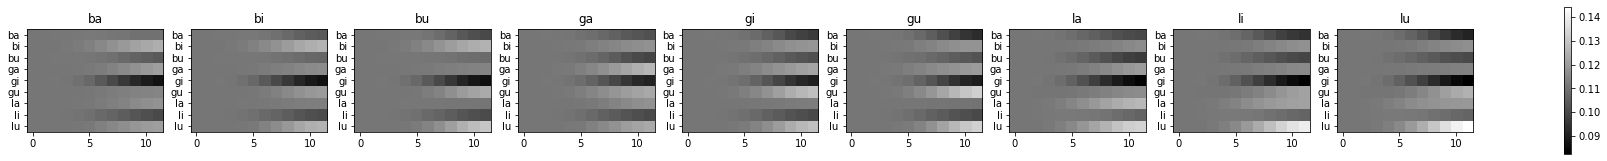

In [30]:
output_test_df["softmaxd_r2_hat"] = output_test_df.apply(lambda x: softmax(x.r2_hat), axis=1)

recon_plots(df=output_test_df.groupby("epoch").get_group(epoch_max),
            ncols=ncols, nrows=nrows, subplot_yx=subplot_yx, scale=scale,
            groupby="label", value="softmaxd_r2_hat", sharey=False, y_label_list=list(I_dict.keys()))

# Accuracy

## Training

In [31]:
output_train_df["argmax_r2_hat"] = output_train_df.apply(lambda x: argmax_1(x.softmaxd_r2_hat), axis=1)
train_recog_df = output_train_df.groupby(["epoch", "label"]).argmax_r2_hat.apply(lambda x: recog(x, steps=5)).rename("recog_node").to_frame()
output_train_df = pd.merge(output_train_df, train_recog_df,
                          left_on=["epoch", "label"], right_on=["epoch", "label"],
                          how="inner", suffixes=("_old", ""))
output_train_df["label_node"] = output_train_df.apply(lambda x: list(I_dict.keys()).index(x.label), axis=1)
output_train_df["accuracy"] = output_train_df.apply(lambda x: int(x.label_node == x.recog_node), axis=1)

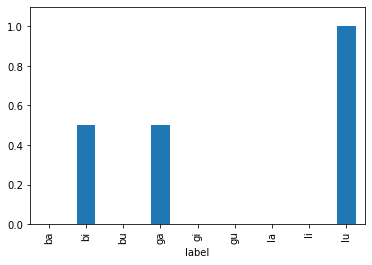

In [32]:
output_train_df.groupby("label").mean().accuracy.plot.bar(ylim=(0, 1.1));

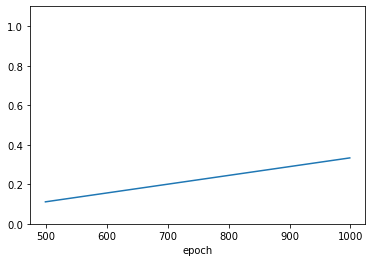

In [33]:
output_train_df.groupby("epoch").mean().accuracy.plot(ylim=(0, 1.1));

## Testing

In [34]:
output_test_df["argmax_r2_hat"] = output_test_df.apply(lambda x: argmax_1(x.softmaxd_r2_hat), axis=1)
test_recog_df = output_test_df.groupby(["epoch", "label"]).argmax_r2_hat.apply(lambda x: recog(x, steps=5)).rename("recog_node").to_frame()
output_test_df = pd.merge(output_test_df, test_recog_df,
                          left_on=["epoch", "label"], right_on=["epoch", "label"],
                          how="inner", suffixes=("_old", ""))
output_test_df["label_node"] = output_test_df.apply(lambda x: list(I_dict.keys()).index(x.label), axis=1)
output_test_df["accuracy"] = output_test_df.apply(lambda x: int(x.label_node == x.recog_node), axis=1)

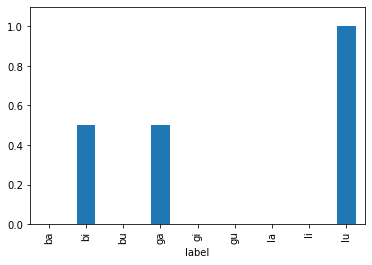

In [35]:
output_test_df.groupby("label").mean().accuracy.plot.bar(ylim=(0, 1.1));

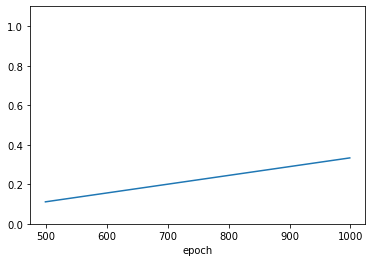

In [36]:
output_test_df.groupby("epoch").mean().accuracy.plot(ylim=(0, 1.1));

# Loss Function Error Terms

## Training

In [37]:
output_train_df["e10"] = 1/s10 * output_train_df.apply(lambda x: x.input - f(x.U1_hat @ x.r1_hat, af=act_func), axis=1).apply(lambda x: x.T @ x)
output_train_df["e11"] = 1/s11 * output_train_df.apply(lambda x: x.r1_hat - x.r1_bar, axis=1).apply(lambda x: x.T @ x)
output_train_df["e21"] = 1/s21 * output_train_df.apply(lambda x: x.r1_hat - f(x.U2_hat @ x.r2_hat, af=act_func), axis=1).apply(lambda x: x.T @ x)
output_train_df["e22"] = 1/s22 * output_train_df.apply(lambda x: x.r2_hat - x.r2_bar, axis=1).apply(lambda x: x.T @ x)
output_train_df["e32"] = 1/s32 * output_train_df.apply(lambda x: -np.sum(x.target_vec * np.log(softmax(x.r2_hat))), axis=1)

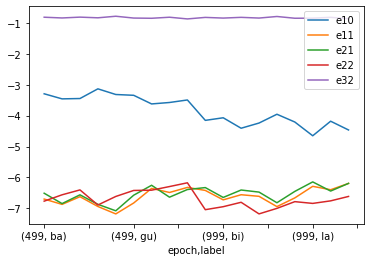

In [38]:
output_train_df.groupby(["epoch", "label"]).mean()[["e10", "e11", "e21", "e22", "e32"]].applymap(lambda x: np.log(x)).plot();

## Testing

In [39]:
output_test_df["e10"] = 1/s10 * output_test_df.apply(lambda x: x.input - f(x.U1_hat @ x.r1_hat, af=act_func), axis=1).apply(lambda x: x.T @ x)
output_test_df["e11"] = 1/s11 * output_test_df.apply(lambda x: x.r1_hat - x.r1_bar, axis=1).apply(lambda x: x.T @ x)
output_test_df["e21"] = 1/s21 * output_test_df.apply(lambda x: x.r1_hat - f(x.U2_hat @ x.r2_hat, af=act_func), axis=1).apply(lambda x: x.T @ x)
output_test_df["e22"] = 1/s22 * output_test_df.apply(lambda x: x.r2_hat - x.r2_bar, axis=1).apply(lambda x: x.T @ x)
output_test_df["e32"] = 1/s32 * output_test_df.apply(lambda x: -np.sum(x.target_vec * np.log(softmax(x.r2_hat))), axis=1)

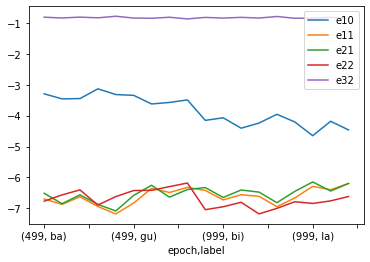

In [40]:
output_test_df.groupby(["epoch", "label"]).mean()[["e10", "e11", "e21", "e22", "e32"]].applymap(lambda x: np.log(x)).plot();

# Weights

In [41]:
timesteps_per_epoch = sum(output_train_df.epoch == epoch_max)

ALL_WEIGHTS_DF = output_train_df.loc[output_train_df.index % timesteps_per_epoch == timesteps_per_epoch - 1]
ALL_WEIGHTS_DF = ALL_WEIGHTS_DF.reset_index(drop=True)

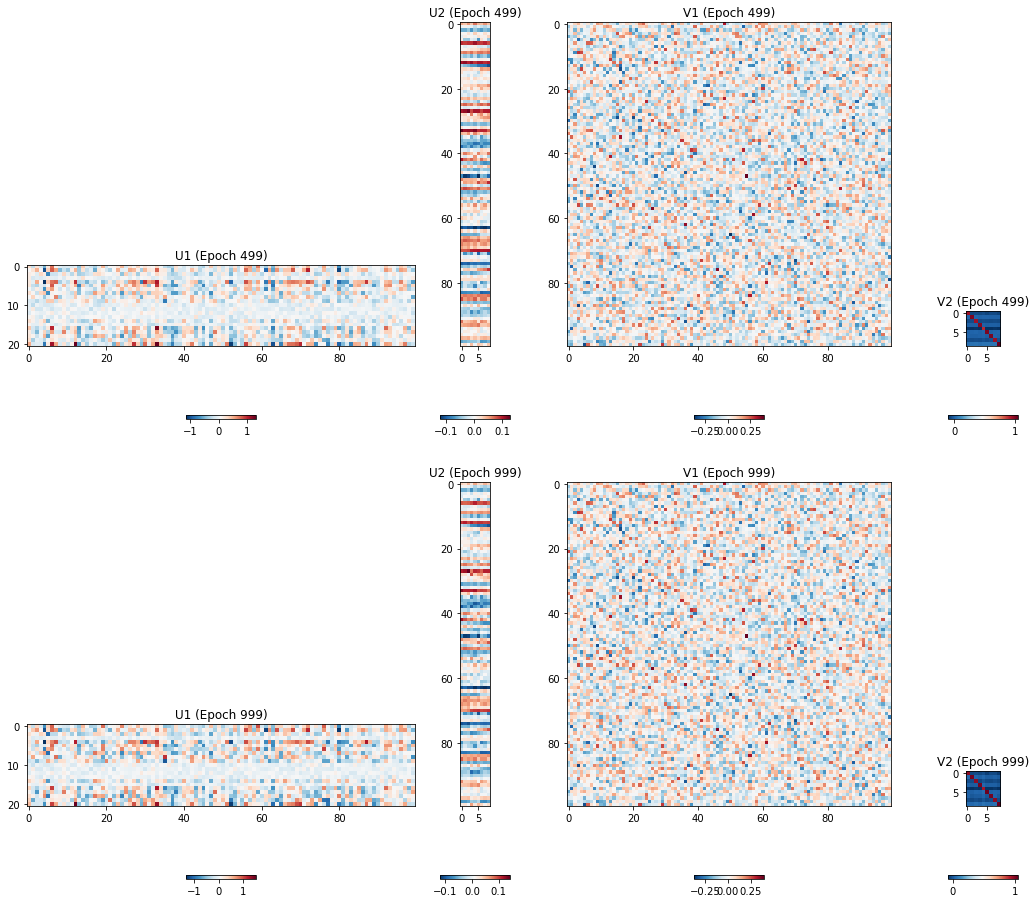

In [42]:
# subplots settings
ncols = 4
nrows = len(ALL_WEIGHTS_DF.index)

weight_shape_list = [U1.shape, U2.shape, V1.shape, V2.shape]

subplot_x = sum([x[1] for x in weight_shape_list]) / 15
subplot_y = max([x[0] for x in weight_shape_list]) / 15
min_x = min([x[1] for x in weight_shape_list]) 

fig, axes = plt.subplots(nrows, ncols, figsize=(subplot_x, subplot_y*nrows),
                         gridspec_kw={'width_ratios': [x[1] for x in weight_shape_list]})

# fig, axes = plt.subplots(nrows, ncols, figsize=(20, 4*nrows))

cmap = "RdBu_r"

for x in range(axes.shape[0]):
    im_0 = axes[x, 0].imshow(ALL_WEIGHTS_DF.U1_hat[x], cmap=cmap)
    im_1 = axes[x, 1].imshow(ALL_WEIGHTS_DF.U2_hat[x], cmap=cmap)
    im_2 = axes[x, 2].imshow(ALL_WEIGHTS_DF.V1_hat[x], cmap=cmap)
    im_3 = axes[x, 3].imshow(ALL_WEIGHTS_DF.V2_hat[x], cmap=cmap)
    
    axes[x, 0].set_title("U1 (Epoch {})".format(ALL_WEIGHTS_DF.epoch[x]))
    axes[x, 1].set_title("U2 (Epoch {})".format(ALL_WEIGHTS_DF.epoch[x]))
    axes[x, 2].set_title("V1 (Epoch {})".format(ALL_WEIGHTS_DF.epoch[x]))
    axes[x, 3].set_title("V2 (Epoch {})".format(ALL_WEIGHTS_DF.epoch[x]))
    
    fig.colorbar(im_0, ax=axes[x, 0], orientation="horizontal", shrink=2*min_x/U1.shape[1]);
    fig.colorbar(im_1, ax=axes[x, 1], orientation="horizontal", shrink=2*min_x/U2.shape[1]);
    fig.colorbar(im_2, ax=axes[x, 2], orientation="horizontal", shrink=2*min_x/V1.shape[1]);
    fig.colorbar(im_3, ax=axes[x, 3], orientation="horizontal", shrink=2*min_x/V2.shape[1]);

plt.tight_layout()